# Address Matching with Apache Spark

## Iniciar Spark

In [1]:
from pyspark.sql.session import SparkSession

spark = (
    SparkSession.builder.appName("Adress Matching")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "20g")
    .config("spark.driver.maxResultSize", "4g")
    .config("spark.local.dir", "/spark-tmp") \
    .getOrCreate()
)

24/05/15 15:29:27 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 10.6.130.30 instead (on interface ens3)
24/05/15 15:29:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/15 15:29:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/15 15:29:28 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/05/15 15:29:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
conf = spark.sparkContext.getConf()
for key, value in conf.getAll():
    print(f"{key}: {value}")

spark.app.name: Adress Matching
spark.executor.memory: 2g
spark.driver.extraJavaOptions: -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false
spark.app.id: local-1715786969547
spark.driver.port: 46

## Lectura de ficheros

El dataset continene exactamente 24 columnas las cuales, el ***, almacena información relevante el trabajo que realizan. En cambio, en este proyecto, se utilizarán las siguientes columnas pues contienen la información más relevante:
- **uuid_idt**: contiene un identificador alfanumérico único para cada dirección.
- **tvia**: contiene el tipo de vía, es decir, si es una calle, avenida, carretera, etc.
- **nvia**: contiene el nombre de la vía.
- **numer**: contiene el número de la vía.
- **codmun**: está compuesto por un código numérico que identifica a un municipio, es decir, el código postal.
- **nommun**: contiene el nombre del municipio.
- **direccion**: contiene la dirección completa."

In [3]:
# Leer el archivo CSV y cargarlo en un DataFrame
file = "../data/raw_data/TFM_Direcciones.tab"
first_df = (
    spark.read.option("delimiter", "\t")
    .option("encoding", "windows-1252")
    .csv(file, header=True, inferSchema=True)
)

# Seleccionar solo las columnas deseadas
selected_columns = [
    "uuid_idt",
    "latitud",
    "longitud",
    "tvia",
    "nvia",
    "numer",
    "codmun",
    "nommun",
    "direccion",
]
first_df = first_df.select(selected_columns)

# Mostrar el DataFrame
first_df.show()
first_df.schema
print(first_df.count())
size_df = first_df.count()

+--------------------+---------+----------+------------+--------------------+-----+------+------+--------------------+
|            uuid_idt|  latitud|  longitud|        tvia|                nvia|numer|codmun|nommun|           direccion|
+--------------------+---------+----------+------------+--------------------+-----+------+------+--------------------+
|027C0FF8-B17B-11E...| 28.10351| -15.71037|       CALLE|        FUENTE SANTA|    5| 35001|Agaete|CALLE FUENTE SANT...|
|028F2302-B17B-11E...| 28.10011| -15.69867|       CALLE|       CRUZ CHIQUITA|    2| 35001|Agaete|CALLE CRUZ CHIQUI...|
|02918516-B17B-11E...| 28.10106| -15.70524|URBANIZACION|RESIDENCIAL PALMERAL|    9| 35001|Agaete|URBANIZACION RESI...|
|03A306C0-7525-11E...| 28.10225| -15.69982|       CALLE|SEÑORITA MARIA MA...|    2| 35001|Agaete|CALLE SEÑORITA MA...|
|03A306C0-7525-11E...| 28.10225| -15.69982|       CALLE|SRTA M MANRIQUE LARA|    2| 35001|Agaete|CALLE SRTA M MANR...|
|03A306C0-7525-11E...| 28.10225| -15.69982|     

1784217


In [4]:
from pyspark.sql.functions import upper

file = "../data/raw_data/data-09022024.csv"
second_df = spark.read.option("header", True).csv(file)

selected_columns = ["uuid_idt", "latitud", "longitud", "codmun", "nommun", "direccion"]

second_df = second_df.select(selected_columns)
second_df = second_df.select(
    upper("uuid_idt").alias("uuid_idt"),
    "latitud",
    "longitud",
    "codmun",
    upper("nommun").alias("nommun"),
    "direccion",
)
second_df.show()
first_df.schema
print(second_df.count())
size_df += second_df.count()

+--------------------+---------+----------+------+--------------------+--------------------+
|            uuid_idt|  latitud|  longitud|codmun|              nommun|           direccion|
+--------------------+---------+----------+------+--------------------+--------------------+
|C0CF3B94-0AD1-11E...| 28.09315| -15.44562| 35016|LAS PALMAS DE GRA...|IGUAZU 42 0 LAS P...|
|73B57C1B-3251-11E...|28.100397|-15.446634| 35016|LAS PALMAS DE GRA...|PARQUE CENTRAL BL...|
|C70E3EC6-3EDA-11E...| 28.12209| -15.43886| 35016|LAS PALMAS DE GRA...|CONCEJAL GARCIA F...|
|687BA81E-3251-11E...|28.128481|-15.508722| 35006|              ARUCAS|PEDRO MORALES DEN...|
|74921989-3251-11E...|27.765042|-15.586671| 35019|SAN BARTOLOMÉ DE ...|ISLA LOBOS 19 0 S...|
|6C0D19FF-3251-11E...|28.112275|-15.419253| 35016|LAS PALMAS DE GRA...|CALLE LEON Y CAST...|
|6360FDCD-3251-11E...|28.116229|-15.443305| 35016|LAS PALMAS DE GRA...|VIGEN PILAR 45 4 ...|
|758B3855-3251-11E...|28.091282|-15.460183| 35016|LAS PALMAS DE GRA...

630297


In [5]:
print(size_df)

2414514


In [6]:
from pyspark.sql.functions import count


def uuid_frecuency(dataframe):
    values_under_10 = (
        dataframe.groupBy(dataframe.uuid_idt)
        .count()
        .filter("count <= 9")
        .groupBy("count")
        .agg(count("*").alias("Frecuencia"))
        .orderBy("count")
    )
    values_under_10 = values_under_10.withColumnRenamed(
        "count", "Número de direcciones asociadas"
    )

    values_over_10 = dataframe.groupBy(dataframe.uuid_idt).count().filter("count > 9")
    values_over_10 = spark.createDataFrame(
        [["10 o más", values_over_10.count()]],
        ["Número de direcciones asociadas", "Frecuencia"],
    )

    values = values_under_10.union(values_over_10)
    values.show()


uuid_frecuency(first_df)
uuid_frecuency(second_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    267275|
|                              2|    115343|
|                              3|     60757|
|                              4|     35631|
|                              5|     22207|
|                              6|     14810|
|                              7|     10142|
|                              8|      7411|
|                              9|      5414|
|                       10 o más|     25539|
+-------------------------------+----------+



+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    250632|
|                              2|     51645|
|                              3|     19692|
|                              4|      9055|
|                              5|      4702|
|                              6|      2876|
|                              7|      1772|
|                              8|      1161|
|                              9|       917|
|                       10 o más|      4083|
+-------------------------------+----------+



## Unión de los dataframes

In [7]:
# Seleccionar los UUID únicos del primer DataFrame
unique_uuid_first_df = first_df.select("uuid_idt").distinct()

# Seleccionar los UUID únicos del segundo DataFrame
unique_uuid_second_df = second_df.select("uuid_idt").distinct()

# Encontrar los UUID comunes
uuid_comunes = unique_uuid_first_df.join(unique_uuid_second_df, "uuid_idt", "inner")
# Da el mismo resultado: uuid_primero.intersect(uuid_segundo)

# Juntar los UUID comunes con el primer DataFrame
addresses_df = first_df.unionByName(
    second_df.join(uuid_comunes, "uuid_idt", "inner"), allowMissingColumns=True
)

# Mostrar el resultado
addresses_df.show()
print("Tamaño del dataframe ampliado: ", addresses_df.count())

# Si se quiere comprobar que la operación es correcta
print(
    "Número de uuid_idt nuevos del segundo dataframe: ",
    unique_uuid_second_df.subtract(uuid_comunes).count(),
)

+--------------------+---------+----------+------------+--------------------+-----+------+------+--------------------+
|            uuid_idt|  latitud|  longitud|        tvia|                nvia|numer|codmun|nommun|           direccion|
+--------------------+---------+----------+------------+--------------------+-----+------+------+--------------------+
|027C0FF8-B17B-11E...| 28.10351| -15.71037|       CALLE|        FUENTE SANTA|    5| 35001|Agaete|CALLE FUENTE SANT...|
|028F2302-B17B-11E...| 28.10011| -15.69867|       CALLE|       CRUZ CHIQUITA|    2| 35001|Agaete|CALLE CRUZ CHIQUI...|
|02918516-B17B-11E...| 28.10106| -15.70524|URBANIZACION|RESIDENCIAL PALMERAL|    9| 35001|Agaete|URBANIZACION RESI...|
|03A306C0-7525-11E...| 28.10225| -15.69982|       CALLE|SEÑORITA MARIA MA...|    2| 35001|Agaete|CALLE SEÑORITA MA...|
|03A306C0-7525-11E...| 28.10225| -15.69982|       CALLE|SRTA M MANRIQUE LARA|    2| 35001|Agaete|CALLE SRTA M MANR...|
|03A306C0-7525-11E...| 28.10225| -15.69982|     

Tamaño del dataframe ampliado:  2234214


Número de uuid_idt nuevos del segundo dataframe:  148073


In [8]:
uuid_frecuency(addresses_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    211768|
|                              2|    119917|
|                              3|     70050|
|                              4|     44000|
|                              5|     28925|
|                              6|     19650|
|                              7|     14050|
|                              8|     10331|
|                              9|      7778|
|                       10 o más|     38060|
+-------------------------------+----------+



In [9]:
from pyspark.sql.functions import col

addresses_df = addresses_df.withColumn(
    "latitud", col("latitud").cast("float")
).withColumn("longitud", col("longitud").cast("float"))

## Partición del dataset

In [10]:
addresses_df = addresses_df.repartition(32)

## Limpieza del dataset

Tras visualizar el dataset, se observa que hay columnas que tienen valores desconocidos, representados con '_U', y camos vacíos.

In [11]:
print(f"Initial dataset size: {addresses_df.count()}")

Initial dataset size: 2234214


### Valores nulos

In [12]:
from pyspark.sql.functions import isnan, when, count, col

addresses_df.select(
    [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in addresses_df.columns]
).show()

+--------+-------+--------+------+------+------+------+------+---------+
|uuid_idt|latitud|longitud|  tvia|  nvia| numer|codmun|nommun|direccion|
+--------+-------+--------+------+------+------+------+------+---------+
|       0|      0|       0|580357|460216|449997|     0|     0|        0|
+--------+-------+--------+------+------+------+------+------+---------+



In [13]:
addresses_df = addresses_df.na.fill("_U")

addresses_df.select(
    [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in addresses_df.columns]
).show()

+--------+-------+--------+----+----+------+------+------+---------+
|uuid_idt|latitud|longitud|tvia|nvia| numer|codmun|nommun|direccion|
+--------+-------+--------+----+----+------+------+------+---------+
|       0|      0|       0|   0|   0|449997|     0|     0|        0|
+--------+-------+--------+----+----+------+------+------+---------+



### Extracción del prefijo para eleminar valores '_U'

Tras analizar el dataset, se observa que para una dirección, el tipo de vía (tvia) puede aparecer vacío, en cambio, en la columna 'direccion' aparece este valor. Por lo que se procederá a extraer el prefijo de la columna 'direccion' para rellenar los valores vacíos de la columna 'tvia' evitando así la perdida de información.

In [14]:
print(
    f"Unknown tvia before prefix extraction: {addresses_df.filter(addresses_df.tvia == '_U').count()}"
)

Unknown tvia before prefix extraction: 580357


In [15]:
tvia_types = addresses_df.select("tvia").distinct().collect()
tvia_types = {t.tvia for t in tvia_types if t.tvia != "_U" and not t.tvia.isnumeric()}
print(tvia_types)

{'COLONIA', 'TRASERA', 'VEREDA', 'URBANIZACION', 'PORTALES', 'VIA PEATONAL', 'CENTRO COMERCIAL', 'POLIGONO', 'DC', 'ANGOSTA', 'PISTA', 'BULEVAR', 'CARRETERA', 'CARRERA', 'PASADIZO', 'PAGO', 'RU', 'CAMIN', 'RINCON', 'AMPLIACION', 'LUGAR', 'ACCESO', 'FINCA', 'CG', 'BARRIO', 'VIA', 'ESTRADA', 'EDIF', 'CORRAL', 'ESCALINATA', 'EDIFICIO', 'CONJUNTO', 'CRTA', 'PASEO ALTO', 'PASEO BAJO', 'PASAJE', 'PASEO', 'ESCALA', 'SERVENTIA', 'LLANO', 'ESCALERA', 'AUTOVIA', 'JARDIN', 'UB', 'AUTOPISTA', 'ALDEA', 'BLOQUES', 'PATIO', 'BARRA', 'ZONA', 'HOTEL', 'LOMO', 'TORRE', 'PARAJE', 'CALLEJON', 'MANZANA', 'BARRIADA', 'RONDA', 'CHALET', 'CAMNO', 'RAMBLA', 'OTROS', 'ALAMEDA', 'CSRIO', 'SOLAR', 'PARQUE', 'TRAV', 'RESIDENCIA', 'COOPERATIVA', 'PROL', 'SUBIDA', 'BCO', 'PLAYA', 'HL', 'SENDA', 'VILLAS', 'AGRUP', 'CALLE', 'BARRANCO', 'BRNCO', 'DISEMINADO', 'CRA', 'PLAZA', 'PRIVADA', 'VIVIENDAS', 'APARTAMENTOS', 'CMINO', 'RAMAL', 'AVENI', 'ATAJO', 'EXTRARRADIO', 'MONTAÑA', 'APARTADO DE CORREOS', 'MUELLE', 'BAJADA', '

In [16]:
from pyspark.sql.functions import regexp_extract, when

condition = (addresses_df.tvia == "_U") & (
    regexp_extract("direccion", r"^(\S+)", 1).isin(tvia_types)
)
addresses_df = addresses_df.withColumn(
    "tvia",
    when(condition, regexp_extract("direccion", r"^(\S+)", 1)).otherwise(
        addresses_df.tvia
    ),
)

In [17]:
print(
    f"Unknown tvia after prefix extraction: {addresses_df.filter(addresses_df.tvia == '_U').count()}"
)

Unknown tvia after prefix extraction: 119382


Se puede observar que los tipos de vías que siguen siendo desconocidos es debido a que desde la columna de dirección no se ha podido extraer un prefijo que aparezca en la lista de los tipos de vías que tenemos en el dataset.

### Limpieza de entradas con valor '_U'

Tras realizar la limpieza del dataset y extraer el tipo de via de la columna 'direccion', se procederá a eliminar las entradas restantes que contengan valores '_U' en las columnas 'tvia' pues no aportan información relevante.

In [18]:
print(
    f"Unknown tvia before duplicated null cleaning: {addresses_df.filter(addresses_df.tvia == '_U').count()}"
)

Unknown tvia before duplicated null cleaning: 119382


In [19]:
addresses_df = addresses_df.filter(addresses_df.tvia != "_U")

In [20]:
print(
    f"Unknown tvia after duplicated null cleaning: {addresses_df.filter(addresses_df.tvia == '_U').count()}"
)

Unknown tvia after duplicated null cleaning: 0


In [21]:
print(f"Tamaño final del dataframe: {addresses_df.count()}")

Tamaño final del dataframe: 2114832


## Aumento de datos

In [22]:
AUMENTED_DATA = False
MIN_FRENCUENCY = 50

### Frecuencia de uuid_idt antes

In [23]:
uuid_frecuency(addresses_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    220637|
|                              2|    117018|
|                              3|     67699|
|                              4|     41588|
|                              5|     27376|
|                              6|     18221|
|                              7|     12864|
|                              8|      9686|
|                              9|      7136|
|                       10 o más|     34919|
+-------------------------------+----------+



### Aumento de datos

- Cambiar el orden de las palabras
- Añadir errores ortográficos
- Añadir sinónimos

In [24]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import random


# Define la función UDF
def switch_letters(direcction: str) -> str:
    """Intercambia letras adyacentes en una palabra.

    Args:
        direction: string with the direction
    """
    words = direcction.split()
    word_candidates = [word for word in words if word.isalpha() and len(word) >= 2]
    if not word_candidates:
        return direcction
    word = random.choice(word_candidates)
    pos = random.randint(0, len(word) - 2)
    return " ".join(
        w if w != word else w[:pos] + w[pos + 1] + w[pos] + w[pos + 2 :] for w in words
    )


def update_direction_via(tvia: str, direction: str) -> str:
    """Actualiza el tipo de vía de la dirección"""
    old_tvia = direction.split(" ")[0]
    if tvia.upper() in tvia_types:
        direction = direction.replace(old_tvia, tvia)
    return direction


def select_via_type(tvia: str) -> list:
    """Selecciona tipos de vía alternativos sin duplicados"""
    return random.choice(
        [t for t in tvia_types if t.title() != tvia and t != tvia.lower()]
    )


unique_filtered_uuids = (
    addresses_df.groupBy("uuid_idt")
    .count()
    .filter(f"count >= {MIN_FRENCUENCY}")
    .select("uuid_idt")
    .sample(0.5)
)

to_extend = addresses_df.join(unique_filtered_uuids, "uuid_idt")

# Registra la función UDF con Spark
spark.udf.register("switch_letters", switch_letters, StringType())
spark.udf.register("select_via_type", select_via_type, StringType())
spark.udf.register("update_direction_via", update_direction_via, StringType())

if (AUMENTED_DATA):
    extended_ds = (
        to_extend.withColumn("tvia", udf(select_via_type, StringType())("tvia"))
        .withColumn(
            "direccion", udf(update_direction_via, StringType())("tvia", "direccion")
        )
        .withColumn("direccion", udf(switch_letters, StringType())("direccion"))
    )

    extended_ds.show(truncate=False)
    print(extended_ds.count(), addresses_df.count())
    addresses_df = addresses_df.union(extended_ds)
    print(addresses_df.count())

### Frecuencia de uuid_idt después

In [25]:
uuid_frecuency(addresses_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    220637|
|                              2|    117018|
|                              3|     67699|
|                              4|     41588|
|                              5|     27376|
|                              6|     18221|
|                              7|     12864|
|                              8|      9686|
|                              9|      7136|
|                       10 o más|     34919|
+-------------------------------+----------+



## Filtros de prueba

In [26]:
MUNICIPIO = "San Cristóbal de La Laguna"

filtered_uuids = (
    addresses_df.groupBy("uuid_idt")
    .count()
    .filter(f"count >= {MIN_FRENCUENCY}")
    .select("uuid_idt")
)

addresses_df = addresses_df.join(filtered_uuids, "uuid_idt").filter(
    f"nommun == '{MUNICIPIO}'"
)

addresses_df = addresses_df.select("uuid_idt", "latitud", "longitud", "direccion")

## División de dataset

In [27]:
# Obtener los uuids únicos y convertirlos a una lista de Python
unique_uuids = [row[0] for row in addresses_df.select("uuid_idt").distinct().collect()]

# Crear DataFrame del 80%
train_df = addresses_df.sampleBy(
    "uuid_idt", fractions={uuid: 0.8 for uuid in unique_uuids}, seed=42
)

# Crear DataFrame del porcentaje restante restando el DataFrame del 80% al original
test_df = addresses_df.subtract(train_df)

In [28]:
""" from pyspark.sql.functions import rand

# Obtener la cantidad mínima de filas por valor único en la columna "uuid_idt"
min_count = addresses_df.groupBy("uuid_idt").count().agg({"count": "min"}).collect()[0][0]

# Crear DataFrames estratificados para el conjunto de entrenamiento y prueba
train_df_stratified = addresses_df.groupBy("uuid_idt").agg(rand(seed=42).alias("rand")).where(f"rand <= 0.8")
test_df_stratified = addresses_df.groupBy("uuid_idt").agg(rand(seed=42).alias("rand")).where(f"rand > 0.8")

# Unir las particiones estratificadas para obtener los DataFrames finales de entrenamiento y prueba
train_df = train_df_stratified.orderBy("uuid_idt").limit(min_count * 0.8)
test_df = test_df_stratified.orderBy("uuid_idt").limit(min_count * 0.2)

# Contar la cantidad de valores únicos en cada DataFrame
train_unique_count = train_df.select("uuid_idt").distinct().count()
test_unique_count = test_df.select("uuid_idt").distinct().count()

print("Cantidad de valores únicos en el conjunto de entrenamiento:", train_unique_count)
print("Cantidad de valores únicos en el conjunto de prueba:", test_unique_count)
 """

' from pyspark.sql.functions import rand\n\n# Obtener la cantidad mínima de filas por valor único en la columna "uuid_idt"\nmin_count = addresses_df.groupBy("uuid_idt").count().agg({"count": "min"}).collect()[0][0]\n\n# Crear DataFrames estratificados para el conjunto de entrenamiento y prueba\ntrain_df_stratified = addresses_df.groupBy("uuid_idt").agg(rand(seed=42).alias("rand")).where(f"rand <= 0.8")\ntest_df_stratified = addresses_df.groupBy("uuid_idt").agg(rand(seed=42).alias("rand")).where(f"rand > 0.8")\n\n# Unir las particiones estratificadas para obtener los DataFrames finales de entrenamiento y prueba\ntrain_df = train_df_stratified.orderBy("uuid_idt").limit(min_count * 0.8)\ntest_df = test_df_stratified.orderBy("uuid_idt").limit(min_count * 0.2)\n\n# Contar la cantidad de valores únicos en cada DataFrame\ntrain_unique_count = train_df.select("uuid_idt").distinct().count()\ntest_unique_count = test_df.select("uuid_idt").distinct().count()\n\nprint("Cantidad de valores únicos e

In [29]:
print(addresses_df.count())
print(train_df.count())
print(test_df.count())

19695


15871


3814


In [30]:
print(addresses_df.select("uuid_idt").distinct().count())
print(train_df.select("uuid_idt").distinct().count())
print(test_df.select("uuid_idt").distinct().count())

211


211


210


In [31]:
uuid_frecuency(train_df)
uuid_frecuency(test_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|         1|
|                              2|         1|
|                       10 o más|       209|
+-------------------------------+----------+



+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|         1|
|                              3|         2|
|                              4|         4|
|                              5|         8|
|                              6|        11|
|                              7|        10|
|                              8|         9|
|                              9|        20|
|                       10 o más|       145|
+-------------------------------+----------+



## Escritura de los dataframes

In [ ]:
# Escribir el resultado en un archivo parquet
try:
    train_df.write.format("parquet").save(
        "../data/proccesed_data/train_dataframe2.parquet"
    )
except:
    print("No se pudo guardar el dataset de entrenamiento.")

24/03/14 17:00:55 WARN DAGScheduler: Broadcasting large task binary with size 28.3 MiB


In [ ]:
# Escribir el resultado en un archivo parquet
try:
    test_df.write.format("parquet").save(
        "../data/proccesed_data/test_dataframe2.parquet"
    )
except:
    print("No se ha podido guardar el dataset de testeo.")

No se ha podido guardar el dataset de testeo.


## Representación gráfica

In [ ]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="direccion", outputCol="words")
tokenized_sentences = tokenizer.transform(addresses_df).select("words").collect()
tokenized_sentences = [sentence.words for sentence in tokenized_sentences]
print(tokenized_sentences[:10])

[['calle', 'sotavento', '118', 'antigua'], ['calle', 'fermina', '55', 'arrecife'], ['calle', 'b', 'villa', 'pirula', '26', 'la', 'oliva'], ['calle', 'bilbao', '55', 'arrecife'], ['calle', 'guanarteme', 'cruce', 'arinaga', '133', 'agüimes'], ['calle', 'dr', 'barnard', '3', 'ingenio'], ['calle', 'palmeral', '1', 'haria'], ['calle', 'verol', 'caleta', 'fuste', '25', 'antigua'], ['calle', 'diama', 'argana', 'alta', '41', 'arrecife'], ['calle', 'camino', 'volcan', 'macher', '7', 'arrecife']]


In [ ]:
word_counter = dict()
for sentence in tokenized_sentences:
    for word in sentence:
        if word not in word_counter:
            word_counter[word] = 1
        else:
            word_counter[word] += 1

word_counter = spark.createDataFrame(word_counter.items(), ["word", "count"]).orderBy(
    "count", ascending=False
)

# Creo la columa frecuencia
word_counter = word_counter.withColumn(
    "frequency", word_counter["count"] / word_counter.count()
)
word_counter.show()

+---------+-------+------------------+
|     word|  count|         frequency|
+---------+-------+------------------+
|    calle|1163401| 9.279369890329013|
|       de| 987371| 7.875341974077767|
|      san| 472800| 3.771086739780658|
|       la| 398688| 3.179964107676969|
|    santa| 284912| 2.272478564307079|
|     gran| 238890|1.9054037886340978|
|  canaria| 227676|1.8159601196410768|
|     cruz| 223350|1.7814556331006979|
|   laguna| 211761|1.6890209371884346|
|cristobal| 210151|1.6761794616151546|
|   palmas| 197517|1.5754097706879362|
|      las| 195800|1.5617148554336988|
| tenerife| 159233|1.2700538384845463|
|        0| 145890| 1.163629112662014|
|  avenida| 124823|0.9955972083748754|
|   camino| 109253|0.8714097706879362|
|        1| 107738|0.8593260219341974|
| tirajana| 105530| 0.841714855433699|
|      los| 102542|0.8178823529411765|
|carretera| 101610|0.8104486540378864|
+---------+-------+------------------+
only showing top 20 rows



<Axes: xlabel='word'>

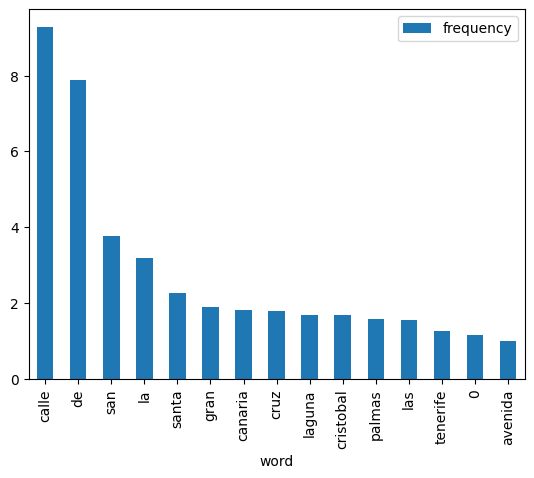

In [ ]:
import matplotlib.pyplot

# Imprimir las 20 palabras más frecuentes
word_counter.toPandas().head(15).plot.bar(x="word", y="frequency")

## Representación con embeddings

### Lectura del dataframe de entrenamiento y validación

In [2]:
try:
    train_df = (
        spark.read.format("parquet")
        .load("../data/proccesed_data/train_dataframe2.parquet")
        .repartition(32)
    )
except:
    print("No se ha podido leer el dataset de entrenamiento.")

In [ ]:
try:
    test_df = (
        spark.read.format("parquet")
        .load("../data/proccesed_data/test_dataframe2.parquet")
        .repartition(32)
    )
except:
    print("No se ha podido leer el dataset de testeo.")

### Representación mediante _Word2Vec_

#### Spark

In [32]:
from pyspark.ml.feature import Word2Vec, Tokenizer

# Tokenizar el texto
tokenizer = Tokenizer(inputCol="direccion", outputCol="words")

train_tokens = tokenizer.transform(train_df)
test_tokens = tokenizer.transform(test_df)

# Entrenar el modelo Word2Vec
word2Vec = Word2Vec(vectorSize=200, minCount=0, inputCol="words", outputCol="embedding")
word2vec_model = word2Vec.fit(train_tokens)

train_embeddings_word2vec  = word2vec_model.transform(train_tokens)
test_embeddings_word2vec  = word2vec_model.transform(test_tokens)

#### Chroma DB

#### Escritura del modelo y del dataset con el embedding

In [ ]:
try:
    word2vec_model.write().overwrite().save("../models/word2vec_model")
except:
    print("No se ha podido guardar el modelo word2vec.")

24/03/19 16:08:22 WARN TaskSetManager: Stage 181 contains a task of very large size (18046 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
try:
    train_embeddings_word2vec.write.format("parquet").save(
        "../data/proccesed_data/train_embeddings_word2vec.parquet"
    )
except:
    print("No se ha podido guardar el dataset con embedding word2vec.")

### Representación con _GPT_

#### Spark

In [32]:
from pyspark.ml.linalg import DenseVector, VectorUDT
from pyspark.sql.functions import udf
from openai import OpenAI


def gtp_embedding(text, model="text-embedding-3-small"):
    client = OpenAI(api_key="***REMOVED***")
    text = text.replace("\n", " ")
    embedding = client.embeddings.create(input=[text], model=model).data[0].embedding
    return DenseVector(embedding)


# Definir la función UDF y especificar el tipo de dato de retorno como VectorUDT()
embedding_udf = udf(lambda text: gtp_embedding(text), VectorUDT())

# Aplicar la función UDF al DataFrame y crear una nueva columna llamada embeddings
gpt3_train_dense_vector = train_df.withColumn(
    "embedding", embedding_udf("direccion")
)

# Aplicar la función UDF al DataFrame y crear una nueva columna llamada embeddings
gpt_test_dense_vector = test_df.withColumn(
    "embedding", embedding_udf("direccion")
)

#### ChromaDB

In [49]:
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import udf
from openai import OpenAI
import numpy as np


def normalize_l2(x):
    x = np.array(x)
    if x.ndim == 1:
        norm = np.linalg.norm(x)
        if norm == 0:
            return x.tolist()  # Convertir a lista si es un vector unidimensional
        return (x / norm).tolist()
    else:
        norm = np.linalg.norm(x, 2, axis=1, keepdims=True)
        return (x / norm).tolist()  # Convertir a lista antes de devolver


def get_embedding(text, model="text-embedding-3-small"):
    client = OpenAI(api_key="***REMOVED***")
    text = text.replace("\n", " ")
    result = client.embeddings.create(input=[text], model=model).data[0].embedding[:256]
    return normalize_l2(result)


# Definir la función UDF y especificar el tipo de dato de retorno como ArrayType(FloatType())
embedding_udf = udf(lambda text: get_embedding(text), ArrayType(FloatType()))

gpt_test_list = test_df.withColumn("embedding", embedding_udf("direccion"))
gpt_train_list = train_df.withColumn("embedding", embedding_udf("direccion"))

### Representación con _MiniLM_

#### Spark

In [30]:
from sentence_transformers import SentenceTransformer
from pyspark.ml.linalg import DenseVector, VectorUDT

model = SentenceTransformer("all-MiniLM-L6-v2")

@udf(returnType=VectorUDT())
def minilm_embedding_dense_vector(text):
    """Calcula el embedding de un texto con MiniLM y devuelve el resultado en el formato especificado."""
    embedding = model.encode(text)
    return DenseVector(embedding)

#### ChromaDB

In [113]:
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import udf
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")


@udf(returnType=ArrayType(FloatType()))
def minilm_embedding_list(direccion: str):
    """Calcula el embedding de la direccion dada y lo convierte a una lista para evitar la serelización de Spark.

    Args:
        direccion: Direction to be represeted by the embedding model.

    Returns:
        A list with de embedding of the direction
    """
    embedding = model.encode(direccion)
    return embedding.tolist()


minilm_train_embedding_list = train_df.withColumn(
    "embedding", minilm_embedding_list("direccion")
)
minilm_test_embedding_list = test_df.withColumn(
    "embedding", minilm_embedding_list("direccion")
)

## Similitud de direcciones

### *TODO*:
- Hacer todo por lotes. Aplicar el crossjoin por lotes y realizar las evaluaciones
- Extraer muestras para realizar las evaluaciones
- Buscar la manera de extraer la informacion para usar Chromadb, es posible aplicar la realizacion por lotes
- Dos opciones: tener dos dataframes en chroma o tener uno pero añadir metadato para diferenciarlos.

### 10/04
- Limitar los datos a un municipio o isla para verlos resultados y comprobar que todo funciona (añadir como metadato el munipio y codigo postal)
- Comprobar cuanto destacan las distancias

### Distancia del coseno

In [29]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
import numpy as np


def cosine_similarity(v1, v2):
    v1_np = np.array(v1)
    v2_np = np.array(v2)
    cos_sim = np.dot(v1_np, v2_np) / (np.linalg.norm(v1_np) * np.linalg.norm(v2_np))
    return float(cos_sim)


cosine_similarity_udf = udf(cosine_similarity, DoubleType())

In [30]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, row_number, expr, max as spark_max
from pyspark.sql.window import Window


def get_top_matches(
    test_df: DataFrame,
    train_df: DataFrame,
    embedding_col: str,
    address_col: str,
    top_n: int = 3,
) -> DataFrame:
    """Return the n top results of the cosine similarity"""
    test_df = test_df.alias("test_df")
    train_df = train_df.alias("train_df")

    cross_df = test_df.crossJoin(train_df)
    cross_df = cross_df.withColumn(
        "cosine_similarity",
        cosine_similarity_udf(
            col(f"test_df.{embedding_col}"), col(f"train_df.{embedding_col}")
        ),
    )

    # Crear una ventana para cada uuid_idt en test_df y ordenar por similitud del coseno
    window = Window.partitionBy(col(f"test_df.{address_col}")).orderBy(
        col("cosine_similarity").desc()
    )

    cross_df = cross_df.withColumn("rank", row_number().over(window))
    top_n_df = cross_df.filter(col("rank") <= top_n)

    return top_n_df


def evaluate_and_count_matches(
    top_n_df: DataFrame, test_id_col: str, train_id_col: str, address_col: str
) -> DataFrame:
    top_n_df = top_n_df.withColumn("evaluation", col(test_id_col) == col(train_id_col))
    
    # top_n_df.select("test_df.uuid_idt", "train_df.uuid_idt", "cosine_similarity", "evaluation").show(truncate=False)

    matches_by_address = top_n_df.groupBy(f"test_df.{address_col}").agg(
        spark_max(expr("case when evaluation = true then 1 else 0 end")).alias(
            "has_match"
        )
    )

    # Filtrar para obtener las direcciones con coincidencias
    matches = matches_by_address.filter("has_match = 1")

    return matches.count()

    """ top_n_df = top_n_df.withColumn("evaluation", expr(f"test_df.{test_id_col} = train_df.{train_id_col}"))

    # Agrupar por la dirección en test_df y contar si alguna de las mejores coincidencias acierta
    matches_by_address = top_n_df.groupBy(col(f"test_df.{address_col}")).agg(
        expr("sum(case when evaluation = true then 1 else 0 end)").alias("match_count")
    )

    # Filtrar para obtener las direcciones con coincidencias
    matches = matches_by_address.filter("match_count > 0")

    return matches """

### Word2Vec

In [33]:
print(train_embeddings_word2vec.count())
print(test_embeddings_word2vec.count())

15871


3812


In [34]:
# Obtener las mejores coincidencias
best_results_df = get_top_matches(
    test_embeddings_word2vec,
    train_embeddings_word2vec,
    "embedding",
    "direccion",
    top_n=3,
)

# Evaluar y contar las coincidencias
matches_count = evaluate_and_count_matches(
    best_results_df, "test_df.uuid_idt", "train_df.uuid_idt", "direccion"
)

# matches_count = matches_by_address.count()
# print(f"Number of addresses with matches: {matches_count}")

# 50 - 29min

#### Evaluación

In [36]:
evaluated_word2vec_cosine.select("evaluation").filter("evaluation == 'True'").count()

24/05/13 16:08:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/13 16:08:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/13 16:08:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/13 16:08:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/13 16:08:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/13 16:08:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/13 16:08:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/13 16:08:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/13 16:09:13 WARN RowBasedKeyValueBatch: Calling spill() on

Py4JJavaError: An error occurred while calling o1270.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 1157.0 failed 1 times, most recent failure: Lost task 4.0 in stage 1157.0 (TID 3748) (10.6.130.30 executor driver): org.apache.spark.memory.SparkOutOfMemoryError: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@36108f35 : No space left on device
	at org.apache.spark.memory.TaskMemoryManager.trySpillAndAcquire(TaskMemoryManager.java:253)
	at org.apache.spark.memory.TaskMemoryManager.acquireExecutionMemory(TaskMemoryManager.java:190)
	at org.apache.spark.memory.TaskMemoryManager.allocatePage(TaskMemoryManager.java:317)
	at org.apache.spark.memory.MemoryConsumer.allocatePage(MemoryConsumer.java:117)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.acquireNewPageIfNecessary(UnsafeExternalSorter.java:433)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:452)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:487)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:226)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.$anonfun$prepareShuffleDependency$10(ShuffleExchangeExec.scala:375)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.memory.SparkOutOfMemoryError: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@36108f35 : No space left on device
	at org.apache.spark.memory.TaskMemoryManager.trySpillAndAcquire(TaskMemoryManager.java:253)
	at org.apache.spark.memory.TaskMemoryManager.acquireExecutionMemory(TaskMemoryManager.java:190)
	at org.apache.spark.memory.TaskMemoryManager.allocatePage(TaskMemoryManager.java:317)
	at org.apache.spark.memory.MemoryConsumer.allocatePage(MemoryConsumer.java:117)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.acquireNewPageIfNecessary(UnsafeExternalSorter.java:433)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:452)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:487)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:226)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.$anonfun$prepareShuffleDependency$10(ShuffleExchangeExec.scala:375)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [40]:
evaluated_word2vec_cosine.filter("evaluation == 'True'").count()

24/05/07 17:26:13 ERROR TaskMemoryManager: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@7564a21
java.io.IOException: No space left on device
	at java.base/java.io.FileOutputStream.writeBytes(Native Method)
	at java.base/java.io.FileOutputStream.write(FileOutputStream.java:354)
	at org.apache.spark.storage.TimeTrackingOutputStream.write(TimeTrackingOutputStream.java:59)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:225)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:178)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:323)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillWriter.write(UnsafeSorterSpillWriter.java:136)
	at org.apache.spark.util.collection.uns

Py4JJavaError: An error occurred while calling o1097.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 1665.0 failed 1 times, most recent failure: Lost task 4.0 in stage 1665.0 (TID 5306) (10.6.130.30 executor driver): org.apache.spark.memory.SparkOutOfMemoryError: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@5f6b8641 : No space left on device
	at org.apache.spark.memory.TaskMemoryManager.trySpillAndAcquire(TaskMemoryManager.java:253)
	at org.apache.spark.memory.TaskMemoryManager.acquireExecutionMemory(TaskMemoryManager.java:190)
	at org.apache.spark.memory.TaskMemoryManager.allocatePage(TaskMemoryManager.java:317)
	at org.apache.spark.memory.MemoryConsumer.allocatePage(MemoryConsumer.java:117)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.acquireNewPageIfNecessary(UnsafeExternalSorter.java:433)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:452)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:487)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:226)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.$anonfun$prepareShuffleDependency$10(ShuffleExchangeExec.scala:375)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.memory.SparkOutOfMemoryError: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@5f6b8641 : No space left on device
	at org.apache.spark.memory.TaskMemoryManager.trySpillAndAcquire(TaskMemoryManager.java:253)
	at org.apache.spark.memory.TaskMemoryManager.acquireExecutionMemory(TaskMemoryManager.java:190)
	at org.apache.spark.memory.TaskMemoryManager.allocatePage(TaskMemoryManager.java:317)
	at org.apache.spark.memory.MemoryConsumer.allocatePage(MemoryConsumer.java:117)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.acquireNewPageIfNecessary(UnsafeExternalSorter.java:433)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:452)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:487)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:226)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.$anonfun$prepareShuffleDependency$10(ShuffleExchangeExec.scala:375)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [25]:
evaluated_word2vec_cosine.select(
    "uuid_idt", "uuid_idt2", "direccion", "direccion2", "cosine_similarity"
).show(truncate=False)

+------------------------------------+------------------------------------+-------------------------------------------------------------------------------+-----------------------------------------------------------------------+-----------------+
|uuid_idt                            |uuid_idt2                           |direccion                                                                      |direccion2                                                             |cosine_similarity|
+------------------------------------+------------------------------------+-------------------------------------------------------------------------------+-----------------------------------------------------------------------+-----------------+
|05DF4E46-4F82-450B-ACF3-E2757D0AE09B|7438477F-3251-11E8-9F08-480FCF5217B3|ANGOSTA CARTA 10 SAN CRISTOBAL DE LA LAGUAN                                    |CRA CANDILA LGAUNA 21 SAN CRISTOBAL DE LA LGAUNA                       |0.91462225       |
|33ECFF0C-9C99-4

In [ ]:
evaluated_word2vec_cosine.select("evaluation").filter("evaluation == true").count()
# 1.000 2min
# 10.000 error

In [ ]:
print(accertion_ratio(evaluated_word2vec_cosine))

### MiniLM

In [33]:
minilm_train_dense_vector = train_df.withColumn(
    "embedding", minilm_embedding_dense_vector(col("direccion"))
)

minilm_test_dense_vector = test_df.withColumn(
    "embedding", minilm_embedding_dense_vector(col("direccion"))
)

In [32]:
minilm_train_dense_vector = train_df.withColumn("embedding", minilm_embedding_dense_vector("direccion"))

minilm_test_dense_vector = test_df.withColumn("embedding", minilm_embedding_dense_vector("direccion"))

In [50]:
minilm_test_dense_vector.limit(10).show(truncate=False)

+------------------------------------+---------+----------+------------+------------------------------------+-----+------+--------------------------+-----------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [58]:
x = minilm_test_dense_vector.filter("direccion == 'PLAZA VICTOR ZURITA SOLER 102 SAN CRISTOBAL DE LA LAGUNA'")
x = x.union(minilm_test_dense_vector.filter("direccion == 'CALLE RECTOR JOSE CARLOS ALBERTO BETHANCOU 7 SAN CRISTOBAL DE LA LAGUNA'"))

In [35]:
evaluated_minilm_cosine = calculate_cosine_similarity(
    minilm_test_dense_vector, minilm_train_dense_vector.limit(1000)
)
# evaluated_minilm_cosine.select("uuid_idt", "direccion", "uuid_idt2", "direccion2").show(10, truncate=False)
# print(evaluated_minilm_cosine.count())
evaluated_minilm_cosine = filter_3_best(evaluated_minilm_cosine)
# print(evaluated_minilm_cosine.count())
evaluated_minilm_cosine = evaluated_minilm_cosine.withColumn(
    "evaluation", evaluated_minilm_cosine.uuid_idt == evaluated_minilm_cosine.uuid_idt2
)

In [61]:
evaluated_minilm_cosine.show()

+--------------------+--------------------+--------------------+--------------------+--------+---------+-----+--------------------+-----+------+--------------------+--------------------+--------------------+-----------------+
|           uuid_idt2|          direccion2|          embedding2|            uuid_idt| latitud| longitud| tvia|                nvia|numer|codmun|              nommun|           direccion|           embedding|cosine_similarity|
+--------------------+--------------------+--------------------+--------------------+--------+---------+-----+--------------------+-----+------+--------------------+--------------------+--------------------+-----------------+
|C075AB21-0AD1-11E...|PLAZA VICTOR ZURI...|[-0.0559375584125...|C075AB21-0AD1-11E...|28.48311|-16.31491|PLAZA| VICTOR ZURITA SOLER|  102| 38023|San Cristóbal de ...|PLAZA VICTOR ZURI...|[-0.0559375584125...|              1.0|
|C075AB21-0AD1-11E...|PLAZA VICTOR ZURI...|[-0.0551847442984...|C075AB21-0AD1-11E...|28.48311|-1

In [36]:
evaluated_minilm_cosine.filter("evaluation == True").count()

24/05/07 17:06:38 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /tmp/blockmgr-456644b8-bf20-45a0-900a-fa5d2d088506/16/temp_shuffle_7c2cf1c0-0dcd-4a9b-a676-01afec15ea2e, No space left on device
24/05/07 17:06:40 ERROR Executor: Exception in task 0.0 in stage 1390.0 (TID 4376)
java.io.IOException: No space left on device
	at java.base/java.io.FileOutputStream.writeBytes(Native Method)
	at java.base/java.io.FileOutputStream.write(FileOutputStream.java:354)
	at org.apache.spark.storage.TimeTrackingOutputStream.write(TimeTrackingOutputStream.java:59)
	at org.apache.spark.io.MutableCheckedOutputStream.write(MutableCheckedOutputStream.scala:43)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:225)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4

Py4JJavaError: An error occurred while calling o908.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1390.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1390.0 (TID 4376) (10.6.130.30 executor driver): java.io.IOException: No space left on device
	at java.base/java.io.FileOutputStream.writeBytes(Native Method)
	at java.base/java.io.FileOutputStream.write(FileOutputStream.java:354)
	at org.apache.spark.storage.TimeTrackingOutputStream.write(TimeTrackingOutputStream.java:59)
	at org.apache.spark.io.MutableCheckedOutputStream.write(MutableCheckedOutputStream.scala:43)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:225)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:178)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:107)
	at org.apache.spark.sql.catalyst.expressions.UnsafeRow.writeToStream(UnsafeRow.java:519)
	at org.apache.spark.sql.execution.UnsafeRowSerializerInstance$$anon$1.writeValue(UnsafeRowSerializer.scala:69)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:312)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.io.IOException: No space left on device
	at java.base/java.io.FileOutputStream.writeBytes(Native Method)
	at java.base/java.io.FileOutputStream.write(FileOutputStream.java:354)
	at org.apache.spark.storage.TimeTrackingOutputStream.write(TimeTrackingOutputStream.java:59)
	at org.apache.spark.io.MutableCheckedOutputStream.write(MutableCheckedOutputStream.scala:43)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:225)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:178)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:107)
	at org.apache.spark.sql.catalyst.expressions.UnsafeRow.writeToStream(UnsafeRow.java:519)
	at org.apache.spark.sql.execution.UnsafeRowSerializerInstance$$anon$1.writeValue(UnsafeRowSerializer.scala:69)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:312)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)


### GPT

In [34]:
evaluated_gpt3_cosine = calculate_cosine_similarity(
    gpt_test_dense_vector, gpt3_train_dense_vector
)
evaluated_gpt3_cosine = filter_3_best(evaluated_gpt3_cosine)
evaluated_gpt3_cosine = evaluated_gpt3_cosine.withColumn(
    "evaluation", evaluated_gpt3_cosine.uuid_idt == evaluated_gpt3_cosine.uuid_idt2
)

In [35]:
evaluated_gpt3_cosine.filter("evaluation == 'True'").count()

24/05/13 12:39:16 ERROR TaskMemoryManager: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@523c1daa
java.io.IOException: No space left on device
	at java.base/java.io.FileOutputStream.writeBytes(Native Method)
	at java.base/java.io.FileOutputStream.write(FileOutputStream.java:354)
	at org.apache.spark.storage.TimeTrackingOutputStream.write(TimeTrackingOutputStream.java:59)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:225)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:178)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:323)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillWriter.write(UnsafeSorterSpillWriter.java:136)
	at org.apache.spark.util.collection.un

Py4JJavaError: An error occurred while calling o1019.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 1002.0 failed 1 times, most recent failure: Lost task 2.0 in stage 1002.0 (TID 3146) (10.6.130.30 executor driver): org.apache.spark.memory.SparkOutOfMemoryError: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@523c1daa : No space left on device
	at org.apache.spark.memory.TaskMemoryManager.trySpillAndAcquire(TaskMemoryManager.java:253)
	at org.apache.spark.memory.TaskMemoryManager.acquireExecutionMemory(TaskMemoryManager.java:190)
	at org.apache.spark.memory.TaskMemoryManager.allocatePage(TaskMemoryManager.java:317)
	at org.apache.spark.memory.MemoryConsumer.allocatePage(MemoryConsumer.java:117)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.acquireNewPageIfNecessary(UnsafeExternalSorter.java:433)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:452)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:487)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:226)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.$anonfun$prepareShuffleDependency$10(ShuffleExchangeExec.scala:375)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.memory.SparkOutOfMemoryError: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@523c1daa : No space left on device
	at org.apache.spark.memory.TaskMemoryManager.trySpillAndAcquire(TaskMemoryManager.java:253)
	at org.apache.spark.memory.TaskMemoryManager.acquireExecutionMemory(TaskMemoryManager.java:190)
	at org.apache.spark.memory.TaskMemoryManager.allocatePage(TaskMemoryManager.java:317)
	at org.apache.spark.memory.MemoryConsumer.allocatePage(MemoryConsumer.java:117)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.acquireNewPageIfNecessary(UnsafeExternalSorter.java:433)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:452)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:487)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:226)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.$anonfun$prepareShuffleDependency$10(ShuffleExchangeExec.scala:375)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)


24/05/13 12:39:18 WARN TaskSetManager: Lost task 7.0 in stage 1002.0 (TID 3151) (10.6.130.30 executor driver): TaskKilled (Stage cancelled: Job aborted due to stage failure: Task 2 in stage 1002.0 failed 1 times, most recent failure: Lost task 2.0 in stage 1002.0 (TID 3146) (10.6.130.30 executor driver): org.apache.spark.memory.SparkOutOfMemoryError: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@523c1daa : No space left on device
	at org.apache.spark.memory.TaskMemoryManager.trySpillAndAcquire(TaskMemoryManager.java:253)
	at org.apache.spark.memory.TaskMemoryManager.acquireExecutionMemory(TaskMemoryManager.java:190)
	at org.apache.spark.memory.TaskMemoryManager.allocatePage(TaskMemoryManager.java:317)
	at org.apache.spark.memory.MemoryConsumer.allocatePage(MemoryConsumer.java:117)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.acquireNewPageIfNecessary(UnsafeExternalSorter.java:433)
	at org.apache.spark.util.coll

In [ ]:
print(accertion_ratio(evaluated_gpt3_cosine))

## Similitud de direcciones con Chroma DB

#### Connect

In [32]:
import chromadb

# Conéctate al cliente de ChromaDB y crea la colección
chroma_client = chromadb.Client()
collection = chroma_client.create_collection(name="address_matching")

In [33]:
from pyspark.ml.linalg import DenseVector
from pyspark.sql import DataFrame


def extract_to_chroma(dataframes):
    embeddings = []
    documents = []
    metadata = []
    ids = []
    start = 0

    for index in range(len(dataframes)):
        type_df = "test" if index == 1 else "train"

        # Extraer los datos restantes como listas
        embeddings_df = dataframes[index].select("embedding").collect()
        documents_df = dataframes[index].select("direccion").collect()
        metadata_df = dataframes[index].select("uuid_idt").collect()
        ids_df = list(range(start, len(embeddings_df) + start))

        # print(type(embeddings_df[0].embedding))
        # Extraer los embeddings como listas
        embeddings_list = []
        for row in embeddings_df:
            if type(row.embedding) != list:
                embeddings_list.append(row.embedding.toArray().tolist())
            else:
                embeddings_list.append(row.embedding)
        embeddings_df = embeddings_list
        # embeddings_df = [row.embedding.toArray().tolist() for row in embeddings_df]

        # Extraer los documentos como listas
        documents_df = [row.direccion for row in documents_df]

        # Extraer los metadatos como listas
        metadata_df = [
            {"uuid_idt": row.uuid_idt, "type_df": type_df} for row in metadata_df
        ]

        ids_df = [str(id_) for id_ in ids_df]

        embeddings += embeddings_df
        documents += documents_df
        metadata += metadata_df
        ids += ids_df
        start = len(ids_df)

    return ids, documents, embeddings, metadata


def extract_to_chroma1(dataframe: DataFrame, type_df: str):
    """Extrac the uuids, directions and embeddings of each row of a dataframe.

    Args:
        dataframe: Dataframe with the data.
        type_df: Type of the dataframe. Train or test.

    Returns:
        embeddings: List with the numeric representation of each direction.
        documents: List that contains the directions.
        metadata: List with relevant information about the direction
          (uuid, latitud, longitud, type_df).
        ids: List with as many ids as addresses.
    """
    ids = []
    documents = []
    embeddings = []
    metadata = []

    # Recopilar los datos del DataFrame
    rows = dataframe.select(
        "uuid_idt", "latitud", "longitud", "direccion", "embedding"
    ).collect()
    index = 0

    for row in rows:
        # Extraer los datos de cada fila
        uuid_idt = str(row.uuid_idt)
        direccion = str(row.direccion)
        embedding = (
            row.embedding.toArray().tolist()
            if isinstance(row.embedding, DenseVector)
            else row.embedding
        )

        # Agregar los datos a las listas correspondientes
        ids.append(str(index))
        documents.append(direccion)
        embeddings.append(embedding)
        metadata.append(
            {
                "uuid_idt": uuid_idt,
                "latitud": float(row.latitud),
                "longitud": float(row.longitud),
                "type_df": type_df,
            }
        )
        index += 1
    return embeddings, documents, metadata, ids


def chunk_data(data, chunk_size: int):
    """
    Divide a list of data into batches of a specific size.

    Args:
        data: The list of data to be divided into batches.
        chunk_size : The size of each batch.

    Yields:
        list: A batch of data of size `chunk_size`.
    """
    for i in range(0, len(data), chunk_size):
        yield data[i : i + chunk_size]


def extract_data(
    test_result_collection: dict, train_result_collection: dict, dataframe
):
    type(test_result_collection)
    """Extract data from the test and train result collections.

    Args:
        test_result_collection (dict): The result collection from the test data.
        train_result_collection (dict): The result collection from the train data.
        dataframe (DataFrame): The DataFrame to write the extracted data.

    Returns:
        DataFrame: A DataFrame containing the extracted data with the following columns:
            - uuid_idt_test
            - latitud_test
            - longitud_test
            - direccion_test
            - uuid_idt_train
            - latitud_train
            - longitud_train
            - direccion_train
    """
    test_metadata = test_result_collection["metadatas"][0]
    uuid_test_result = test_metadata["uuid_idt"]
    latitud_test_result = test_metadata["latitud"]
    longitud_test_result = test_metadata["longitud"]
    direccion_test_result = test_result_collection["documents"][0]
    test_data = (
        uuid_test_result,
        latitud_test_result,
        longitud_test_result,
        direccion_test_result,
    )

    # Datos de entrenamiento
    train_metadata = train_result_collection["metadatas"][0]
    train_data = [
        (metadata["uuid_idt"], metadata["latitud"], metadata["longitud"], direccion)
        for metadata, direccion in zip(
            train_metadata, train_result_collection["documents"][0]
        )
    ]

    # Crear DataFrames temporales y unirlos
    temp_data = [(test_data + train_row) for train_row in train_data]
    temp_df = spark.createDataFrame(temp_data, schema=schema)
    dataframe = dataframe.union(temp_df)
    return dataframe


""" def extract_data(test_result_collection, train_result_collection):
  global evaluated_no_match_dirs
  uuid_test_result = test_result_collection["metadatas"][0]["uuid_idt"]
  latitud_test_result = test_result_collection["metadatas"][0]["latitud"]
  longitud_test_result = test_result_collection["metadatas"][0]["longitud"]
  direccion_test_result = test_result_collection["documents"][0]
  
  test_data = (uuid_test_result, latitud_test_result, longitud_test_result, direccion_test_result)
  
  train_data = []
  for index in range(len(train_result_collection["ids"][0])):
    metadata = train_result_collection["metadatas"][0]
    uuid_train_result = metadata[index]["uuid_idt"]
    latitud_train_result = metadata[index]["latitud"]
    longitud_train_result = metadata[index]["longitud"]
    direccion_train_result = train_result_collection["documents"][0][index]
    
    train_data.append((uuid_train_result, latitud_train_result, longitud_train_result, direccion_train_result))

  # Creación de DataFrame para cada dato de entrenamiento y unión con el DataFrame del conjunto de prueba
  df_rows = [(test_data + result) for result in train_data]
  df = spark.createDataFrame(df_rows, schema)
  
  # Uniones de DataFrames
  evaluated_no_match_dirs = evaluated_no_match_dirs.union(df) """


def evaluation(
    collection_test: chromadb.api.models.Collection.Collection,
    collection_train: chromadb.api.models.Collection.Collection,
    max_id: int,
):
    """
    Args:
        collection_test: Collection with the data to search for similar.
        collection_train: Collection to query the n best embeddings.
        max_id: Max id to iterate.

    Returns: 
        match: Number of hits.
        no_match: Numbers of no hits.
        evaluated_dirs: Dataframe with the made comparations.
    """
    evaluated_dirs = spark.createDataFrame([], schema)

    counter = 0
    match = 0
    no_match = 0
    while counter < max_id:
        # Select from test df
        result = collection_test.get(
            ids=[str(counter)], include=["embeddings", "metadatas", "documents"]
        )

        # Embedding and uuid from test df
        embedding_to_evaluate = result["embeddings"][0]
        uuid_to_evaluate = result["metadatas"][0]["uuid_idt"]

        # Generate best similarities
        best_similarities = collection_train.query(
            query_embeddings=[embedding_to_evaluate], n_results=3
        )

        best_uuids = [u["uuid_idt"] for i in best_similarities["metadatas"] for u in i]

        if uuid_to_evaluate in best_uuids:
            match += 1
        else:
            no_match += 1
            evaluated_dirs = extract_data(result, best_similarities, evaluated_dirs)
        counter += 1
    return match, no_match, evaluated_dirs


def add_to_collection(
    collection: chromadb.api.models.Collection.Collection, 
    embeddings_list: list, 
    documents_list: list, 
    metadata_list: list, 
    ids_list: list
):
    """
    Add elements to a collection.

    Args:
        collection: The collection to which the elements will be added.
        embeddings_list (list): A list of embeddings.
        documents_list (list): A list of documents.
        metadata_list (list): A list of metadata.
        ids_list (list): A list of IDs.

    Returns:
        None
    """
    batch_size = 41666
    embeddings_chunks = list(chunk_data(embeddings_list, batch_size))
    documents_chunks = list(chunk_data(documents_list, batch_size))
    metadata_chunks = list(chunk_data(metadata_list, batch_size))
    ids_chunks = list(chunk_data(ids_list, batch_size))

    # Agrega cada lote por separado a la colección
    for embeddings, documents, metadata, ids in zip(
        embeddings_chunks, documents_chunks, metadata_chunks, ids_chunks
    ):
        collection.add(
            embeddings=embeddings, documents=documents, metadatas=metadata, ids=ids
        )


schema = "uuid_idt_test: string, \
        latitud_test: float, \
        longitud_test: float, \
        direccion_test: string, \
        uuid_idt_train: string, \
        latitud_train: float, \
        longitud_train: float, \
        direccion_train: string"

#### Word2Vec

In [12]:
ids_list, documents_list, embeddings_list, metadata_list = extract_to_chroma1(
    test_embeddings_word2vec, "test"
)
collection_test_w2v = chroma_client.create_collection(name="test_df_w2v")
add_to_collection(
    collection_test_w2v, ids_list, documents_list, embeddings_list, metadata_list
)  # ?min

In [13]:
ids_list, documents_list, embeddings_list, metadata_list = extract_to_chroma1(
    train_embeddings_word2vec, "train"
)
collection_train_w2v = chroma_client.create_collection(name="train_df_w2v")
add_to_collection(
    collection_train_w2v, ids_list, documents_list, embeddings_list, metadata_list
)  # 21min

In [29]:
matches_count, no_matches_count = evaluation(
    collection_test_w2v, collection_train_w2v, test_embeddings_word2vec.count() - 1
)
print(match, no_match)

15841 67160


In [ ]:
""" max_id = w2v_cosine.count() + word2vec_result.count() - 1
counter = w2v_cosine.count()
yes = 0
no = 0
while counter < max_id:
  # Select from train df
  result = collection.get(
    ids=[str(counter)],
    include=["embeddings", "metadatas", "documents"]
  )

  # print(result)
  # print(result["embeddings"][0])
  # print(result["metadatas"][0]["uuid_idt"])
  
  # Embedding from train df
  e1 = result["embeddings"][0]
  u1 = result["metadatas"][0]["uuid_idt"]

  # Generate best similarities
  # TODO: filtrar antes por aquellos embeddings que son de "train"
  results_q = collection.query(
    query_embeddings=[e1],
    n_results=2,
  )

  uuids = [u["uuid_idt"] for i in results_q["metadatas"] for u in i]
  # print(uuids)

  if u1 in uuids:
    yes+=1
    print(result)
    print("--------")
    print(results_q)
  else:
    no+=1
  counter+=1

print(yes)
print(no) """

{'ids': [['90351', '33999', '130209', '91576', '140145']], 'distances': [[0.0, 0.19808949530124664, 0.20216217637062073, 0.20269343256950378, 0.22468826174736023]], 'metadatas': [[{'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '6BD93CCB-3251-11E8-9BFD-480FCF5217B3'}, {'hnsw:space': 'cosine', 'type': 'train', 'uuid_idt': '683E27B8-3251-11E8-B413-480FCF5217B3'}, {'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '6091C9B3-3251-11E8-BB6A-480FCF5217B3'}, {'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '737D7422-1C73-476A-815F-292B1C2C11DD'}, {'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '6273B1E0-3251-11E8-A556-480FCF5217B3'}]], 'embeddings': None, 'documents': [['CAMIN BOQUERON VALEL GUERRA 189 SAN CRISTOBAL DE LA LAGUNA', 'CG CARRETERA BOQUERON VALEL GUERRA 29 SAN CRISTOBAL DE LA LAGUNA', 'EXTRARRADIO VINO AVLLE GUERRA 357 SAN CRISTOBAL DE LA LAGUNA', 'DEIF BOQUERON VALLE GUERRA 85 SAN CRISTOBAL DE LA LAGUNA', 'CALLE BOQUERON VALLE GUERRA 214 SAN CRISTOBAL DE LA LAGUN

' # print(uuids)\nif u1 in uuids:\n  yes+=1\n  print(result)\n  print("--------")\n  print(results_q)\nelse:\n  no+=1\ncounter+=1\n\nprint(yes)\nprint(no) '

#### GPT

In [50]:
chroma_client.delete_collection("test_df")
chroma_client.delete_collection("train_df")

In [51]:
collection_test_gpt = chroma_client.create_collection(name="test_df")
collection_train_gpt = chroma_client.create_collection(name="train_df")

In [52]:
ids_list, documents_list, embeddings_list, metadata_list = extract_to_chroma1(
    gpt_test_list, "test"
)
add_to_collection(
    collection_test_gpt, ids_list, documents_list, embeddings_list, metadata_list
)  # xmin

In [53]:
ids_list, documents_list, embeddings_list, metadata_list = extract_to_chroma1(
    gpt_train_list, "train"
)
add_to_collection(
    collection_train_gpt, ids_list, documents_list, embeddings_list, metadata_list
)  # xmin

In [54]:
print(gpt_test_list.count(), collection_test_gpt.count())
print(gpt_train_list.count(), collection_train_gpt.count())

3320 3320


13959 13957


In [56]:
matches_count, no_matches_count, best_results_df = evaluation(
    collection_test_gpt, 
    collection_train_gpt, 
    collection_test_gpt.count() - 1
)
print(match, no_match)

3078 241


#### MiniLLM

In [ ]:
""" from pyspark.sql.functions import udf

@udf(returnType=ArrayType(FloatType()))
def minilm_embedding_list(direccion):
    """Calcula el embedding de la dirección dada y lo convierte a una lista para evitar la serialización de Spark."""
    # Sentences are encoded by calling model.encode()
    embedding = model.encode(direccion)
    # Convertir el embedding a una lista de Python para evitar la serialización
    return embedding.tolist()

model = SentenceTransformer("all-MiniLM-L6-v2")

minilm_result = train_df.withColumn("embedding", minilm_embedding_list("direccion"))
minilm_cosine = test_df.withColumn("embedding", minilm_embedding_list("direccion")) """

In [114]:
chroma_client.delete_collection("test_df_minilm")

In [115]:
chroma_client.delete_collection("train_df_minilm")

In [116]:
collection_test_minilm = chroma_client.create_collection(name="test_df_minilm")

In [117]:
collection_train_minilm = chroma_client.create_collection(name="train_df_minilm")

In [118]:
print(minilm_train_embedding_list.count())
print(minilm_test_embedding_list.count())

21134


5122


In [119]:
embeddings_list, documents_list, metadata_list, ids_list = extract_to_chroma1(
    minilm_test_embedding_list, "test"
)
add_to_collection(
    collection_test_minilm, embeddings_list, documents_list, metadata_list, ids_list
)  # 9min

In [120]:
embeddings_list, documents_list, metadata_list, ids_list = extract_to_chroma1(
    minilm_train_embedding_list, "train"
)
add_to_collection(
    collection_train_minilm, embeddings_list, documents_list, metadata_list, ids_list
)  # 11min

In [121]:
matches_count, no_matches_count, best_results_df = evaluation(
    collection_test_minilm, 
    collection_train_minilm, 
    collection_test_minilm.count() - 1
)
print(match, no_match)

4735 386


In [39]:
evaluated_dirs.show(10, truncate=False)

24/05/06 12:54:46 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
24/05/06 12:54:47 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
24/05/06 12:54:47 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
24/05/06 12:54:48 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


+------------------------------------+------------+-------------+---------------------------------------------------------------------+------------------------------------+-------------+--------------+----------------------------------------------------------+
|uuid_idt_test                       |latitud_test|longitud_test|direccion_test                                                       |uuid_idt_train                      |latitud_train|longitud_train|direccion_train                                           |
+------------------------------------+------------+-------------+---------------------------------------------------------------------+------------------------------------+-------------+--------------+----------------------------------------------------------+
|67842392-3251-11E8-B06D-480FCF5217B3|28.478521   |-16.308836   |CALLE ESC AGUIAR SOTO RES DRAGO FASE II 30 SAN CRISTOBAL DE LA LAGUNA|60F6009A-3251-11E8-B7C6-480FCF5217B3|28.49091     |-16.322086    |CALLE ESPINAL 19

In [41]:
addresses_df.filter(
    "direccion == 'CARRETERA CTRA GRAL ORTIGAL 211 SAN CRISTOBAL DE LA LAGUNA'"
).show(truncate=False)

+------------------------------------+---------+----------+---------+-----------------+-----+------+--------------------------+----------------------------------------------------------+
|uuid_idt                            |latitud  |longitud  |tvia     |nvia             |numer|codmun|nommun                    |direccion                                                 |
+------------------------------------+---------+----------+---------+-----------------+-----+------+--------------------------+----------------------------------------------------------+
|692A201D-3251-11E8-B4A5-480FCF5217B3|28.489901|-16.372274|CARRETERA|CTRA GRAL ORTIGAL|211  |38023 |San Cristóbal de La Laguna|CARRETERA CTRA GRAL ORTIGAL 211 SAN CRISTOBAL DE LA LAGUNA|
+------------------------------------+---------+----------+---------+-----------------+-----+------+--------------------------+----------------------------------------------------------+



In [ ]:
TODO: 
- probar con proporción 90 - 10
1. ver si las direcciones mal clasificadas están próximas a estar bien clasificadas. Agregar las coordenadas al df y en el caso de estar mal clasificadas, ver por cuanto fallan. Extraer 100 de cada caso (bien y mal clasificado)
- Usar 200 mil direcciones para calcular los embeddings usando la API de OpenAI dada

In [ ]:
- Probar con frecuencias de 10, 30, 50, 100 dependiendo si los resultados mejoran mucho o no
- Sacar el csv solo con los caso de no match
- Sacar metricas con la distancia de haversine, media, máxima, etc, con los 3 o con el mejor

## Evaluación

In [36]:
from pyspark.sql.functions import col, udf
from haversine import haversine
from pyspark.sql.types import DoubleType

# Definir una función UDF (User Defined Function) para aplicar haversine
haversine_udf = udf(
    lambda lat1, lon1, lat2, lon2: haversine((lat1, lon1), (lat2, lon2)),
    returnType=DoubleType(),
)

# Aplicar la función UDF a las columnas del DataFrame
evaluated_dirs = best_results_df.withColumn(
    "haversine_distance",
    haversine_udf(
        col("test_df.latitud"),
        col("test_df.longitud"),
        col("train_df.latitud"),
        col("train_df.longitud"),
    ),
)

In [ ]:
evaluated_dirs.coalesce(1).write.csv("../data/proccesed_data/.csv")

In [ ]:
evaluated_dirs.show(truncate=False)

In [37]:
evaluated_dirs = evaluated_dirs.repartition(32)

In [ ]:
evaluated_dirs.show()

In [38]:
from pyspark.sql.functions import avg

mean_value = round(evaluated_dirs.agg(avg("haversine_distance")).collect()[0][0], 2)
# max_value = round(evaluated_dirs.agg({"haversine_distance": "max"}).collect()[0][0], 2)

In [38]:
print(mean_value)

0.0


In [ ]:
modelo = 'Word2Vec'
# modelo = 'GTP'
# modelo = "MiniLM"
tecnology = 'Spark'
# tecnology = "Chroma DB"
hit_rate = round(matches_count / test_df.count(), 2)

In [62]:
print(hit_rate)

0.93


In [ ]:
print(matches_count)
print(test_df.count())

In [ ]:
import csv
import os


def write_model_results(cabecera: list, data: list):
    """Create or write the data into a csv file."""
    csv_file_path = f"../data/proccesed_data/results.csv"
    escribir_cabecera = not os.path.exists(csv_file_path)

    with open(csv_file_path, mode="a", newline="") as file:
        writer = csv.writer(file)
        if escribir_cabecera:
            writer.writerow(cabecera)
        writer.writerows(data)

    print(f"CSV file '{csv_file_path}' created successfully.")


cabecera = [
    "Model",
    "Tecnology",
    "Municipaly",
    "Train dataset size",
    "Test dataframe size",
    "Aumented data",
    "Frecuency",
    "Hit rate",
    "Mean Haversine distance",
    # "Max Haversine distance",
]

data = [
    [
        modelo,
        tecnology,
        MUNICIPIO,
        train_df.count(),
        test_df.count(),
        AUMENTED_DATA,
        MIN_FRENCUENCY,
        hit_rate,
        mean_value,
        # max_value,
    ]
]

write_model_results(cabecera, data)

CSV file '../data/proccesed_data/results.csv' created successfully.
